# Building Content-Based and Collaborative Filtering Movie Recommenders with TMDB Data

## Introduction

Welcome to the **TMDB Movies Recommendation System** notebook! In this project, we leverage the **Top 10k TMDB Movies Dataset** to build two distinct recommendation engines:

1. **Content-Based Recommender**: Utilizes movie metadata such as genres, overviews, and other textual features to find similar movies.
2. **Collaborative Filtering Recommender**: Employs user interaction data (like vote averages and counts) to identify patterns and recommend movies based on user preferences.

Additionally, we perform a comparative analysis of both systems to understand their strengths and weaknesses. This notebook is structured into five main sections:

1. **Imports and Utility Functions**
2. **Setup and Data Loading**
3. **Content-Based Recommender**
4. **Collaborative Filtering Recommender**
5. **Comparison Analysis**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-rated-tmdb-movies-10k/top10K-TMDB-movies.csv


## Imports and Utility Functions

In this initial cell, we import all necessary libraries and define essential functions and classes required for data loading, preprocessing, and building the recommendation systems.

**Description:**
- **Imports**: Essential libraries for data manipulation (`pandas`, `numpy`), machine learning (`sklearn`), visualization (`seaborn`, `matplotlib`), and progress tracking (`tqdm`).
- **`load_and_prepare_data` Function**: Loads the dataset, handles missing values, ensures correct data types, and cleans the data for further processing.
- **`ContentBasedRecommender` Class**: Implements the content-based recommendation system using TF-IDF vectorization and cosine similarity.
- **`CollaborativeFilteringRecommender` Class**: Implements the collaborative filtering recommendation system based on weighted ratings and cosine similarity.
- **Visualization Functions**: 
  - `plot_recommendation_metrics`: Visualizes various metrics of the recommendations.
  - `compare_recommendations`: Compares metrics between the two recommendation systems.
- **`calculate_recommendation_metrics` Function**: Computes evaluation metrics to assess the quality of recommendations.


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from tqdm import tqdm

# Update the seaborn style settings
sns.set_theme(style="whitegrid")           # Use seaborn's native styling
plt.rcParams['figure.figsize'] = (15, 10)  # Set default figure size

def load_and_prepare_data(file_path):
    """Load and prepare the TMDB movies dataset."""
    print("Loading data...")
    movies_df = pd.read_csv(file_path)
    
    # Fill NaN values with empty strings for text columns
    movies_df['overview'] = movies_df['overview'].fillna('')
    movies_df['genre'] = movies_df['genre'].fillna('[]')
    
    # Convert numeric columns and handle inf values
    numeric_columns = ['vote_average', 'vote_count', 'popularity']
    for col in numeric_columns:
        # Convert to numeric and replace inf with NaN
        movies_df[col] = pd.to_numeric(movies_df[col], errors='coerce')
        movies_df[col] = movies_df[col].replace([np.inf, -np.inf], np.nan)
        movies_df[col] = movies_df[col].fillna(0)
    
    # Remove rows where title is NaN
    movies_df = movies_df.dropna(subset=['title'])
    return movies_df


class ContentBasedRecommender:
    """A content-based recommendation system that recommends movies similar to a given movie based on textual features like overview and genre."""
    
    def __init__(self):
        """Initialize the ContentBasedRecommender with a TF-IDF vectorizer and placeholders for similarity matrix and movie data."""
        self.tfidf = TfidfVectorizer(stop_words='english')  # Initialize TF-IDF Vectorizer with English stop words
        self.cosine_sim = None  # Placeholder for the cosine similarity matrix
        self.movies = None  # Placeholder for the movies DataFrame
    
    def preprocess_text(self, text):
        """
        Clean and preprocess text data by converting to lowercase and stripping whitespace.
        
        Parameters:
            text (str): The text to preprocess.
        
        Returns:
            str: The cleaned and preprocessed text.
        """
        if pd.isna(text) or text == '':
            return ''
        return str(text).lower().strip()
        
    def fit(self, movies_df):
        """
        Fit the recommender system to the provided movies DataFrame by preprocessing text features,
        creating a TF-IDF matrix, and computing the cosine similarity matrix.
        
        Parameters:
            movies_df (pd.DataFrame): The DataFrame containing movie data.
        """
        self.movies = movies_df.copy()
        
        # Preprocess text features
        print("Preprocessing text features...")
        self.movies['overview'] = self.movies['overview'].apply(self.preprocess_text)
        self.movies['genre'] = self.movies['genre'].apply(self.preprocess_text)
        
        # Combine features into a single text field
        text_features = (self.movies['overview'] + ' ' + self.movies['genre']).fillna('')
        
        # Create TF-IDF matrix from the combined text features
        print("Creating TF-IDF matrix...")
        tfidf_matrix = self.tfidf.fit_transform(text_features)
        
        # Calculate cosine similarity matrix based on the TF-IDF features
        print("Calculating content-based similarity matrix...")
        self.cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
        print("Content-based similarity matrix calculated!")
        
    def recommend(self, movie_title, n_recommendations=5):
        """
        Recommend a list of movies similar to the given movie title based on the cosine similarity scores.
        
        Parameters:
            movie_title (str): The title of the movie for which to find recommendations.
            n_recommendations (int): The number of recommendations to return.
        
        Returns:
            pd.DataFrame: A DataFrame containing the recommended movies with their details and similarity scores.
        """
        try:
            # Get index of the movie in the DataFrame
            idx = self.movies[self.movies['title'] == movie_title].index[0]
            
            # Get similarity scores for all movies compared to the selected movie
            sim_scores = list(enumerate(self.cosine_sim[idx]))
            
            # Sort the movies based on similarity scores in descending order
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            
            # Select the top N most similar movies, excluding the first one (which is the movie itself)
            sim_scores = sim_scores[1:n_recommendations+1]
            movie_indices = [i[0] for i in sim_scores]
            
            # Retrieve the recommended movies' details
            recommendations = self.movies.iloc[movie_indices][
                ['title', 'genre', 'vote_average', 'popularity', 'overview']
            ]
            recommendations['similarity_score'] = [i[1] for i in sim_scores]  # Add similarity scores to the recommendations
            return recommendations
                
        except IndexError:
            # Handle the case where the movie title is not found in the dataset
            print(f"Movie '{movie_title}' not found in the dataset.")
            return pd.DataFrame()


class CollaborativeFilteringRecommender:
    """A collaborative filtering recommendation system that recommends movies based on user interaction data such as vote averages and counts."""
    
    def __init__(self):
        """Initialize the CollaborativeFilteringRecommender with placeholders for user-movie matrix, similarity matrix, and movie data."""
        self.user_movie_matrix = None  # Placeholder for the user-movie interaction matrix
        self.similarity_matrix = None  # Placeholder for the item-item similarity matrix
        self.movies = None  # Placeholder for the movies DataFrame
        
    def fit(self, movies_df):
        """
        Fit the recommender system to the provided movies DataFrame by creating a user-movie matrix,
        calculating weighted ratings, and computing the cosine similarity matrix.
        
        Parameters:
            movies_df (pd.DataFrame): The DataFrame containing movie data.
        """
        self.movies = movies_df.copy()
        
        print("Creating user-movie matrix...")
        
        # Calculate the mean vote average across all movies (C)
        C = self.movies['vote_average'].mean()
        # Calculate the minimum number of votes required to be considered (m) using the 90th percentile
        m = self.movies['vote_count'].quantile(0.90)
        
        # Compute the weighted rating for each movie using the IMDB formula
        self.movies['weighted_rating'] = (
            (self.movies['vote_count'] * self.movies['vote_average']) + (m * C)
        ) / (self.movies['vote_count'] + m)
        
        # Create the user-movie interaction matrix using pivot table
        self.user_movie_matrix = pd.pivot_table(
            self.movies,
            values='weighted_rating',
            index='id',
            aggfunc='mean'
        ).fillna(0)  # Fill missing values with 0
        
        # Calculate the item-item cosine similarity matrix based on the user-movie matrix
        print("Calculating collaborative filtering similarity matrix...")
        self.similarity_matrix = cosine_similarity(self.user_movie_matrix)
        print("Collaborative filtering similarity matrix calculated!")
        
    def recommend(self, movie_title, n_recommendations=5):
        """
        Recommend a list of movies similar to the given movie title based on the collaborative filtering similarity scores.
        
        Parameters:
            movie_title (str): The title of the movie for which to find recommendations.
            n_recommendations (int): The number of recommendations to return.
        
        Returns:
            pd.DataFrame: A DataFrame containing the recommended movies with their details and similarity scores.
        """
        try:
            # Get the movie ID corresponding to the given movie title
            movie_id = self.movies[self.movies['title'] == movie_title]['id'].iloc[0]
            
            # Get the index of the movie ID in the user-movie matrix
            idx = self.user_movie_matrix.index.get_loc(movie_id)
            
            # Get similarity scores for all movies compared to the selected movie
            sim_scores = list(enumerate(self.similarity_matrix[idx]))
            
            # Sort the movies based on similarity scores in descending order
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            
            # Select the top N most similar movies, excluding the first one (which is the movie itself)
            sim_scores = sim_scores[1:n_recommendations+1]
            movie_indices = [self.user_movie_matrix.index[i[0]] for i in sim_scores]
            
            # Retrieve the recommended movies' details
            recommendations = self.movies[self.movies['id'].isin(movie_indices)][
                ['title', 'genre', 'vote_average', 'weighted_rating', 'popularity', 'overview']
            ]
            recommendations['similarity_score'] = [i[1] for i in sim_scores]  # Add similarity scores to the recommendations
            return recommendations
                
        except IndexError:
            # Handle the case where the movie title is not found in the dataset
            print(f"Movie '{movie_title}' not found in the dataset.")
            return pd.DataFrame()


def plot_recommendation_metrics(recommendations_df, title):
    """Create visualizations for recommendation metrics"""
    # Create figure with updated style
    fig = plt.figure(figsize=(15, 12))
    gs = plt.GridSpec(2, 2, figure=fig)
    fig.suptitle(title, fontsize=16, y=1.02)
    
    # Similarity Score Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(data=recommendations_df, x='similarity_score', bins=20, ax=ax1)
    ax1.set_title('Similarity Score Distribution')
    ax1.set_xlabel('Similarity Score')
    
    # Vote Average vs Similarity
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(data=recommendations_df, x='vote_average', y='similarity_score', ax=ax2)
    ax2.set_title('Vote Average vs Similarity')
    ax2.set_xlabel('Vote Average')
    ax2.set_ylabel('Similarity Score')
    
    # Popularity vs Similarity
    ax3 = fig.add_subplot(gs[1, 0])
    sns.scatterplot(data=recommendations_df, x='popularity', y='similarity_score', ax=ax3)
    ax3.set_title('Popularity vs Similarity')
    ax3.set_xlabel('Popularity')
    ax3.set_ylabel('Similarity Score')
    
    # Genre Distribution
    ax4 = fig.add_subplot(gs[1, 1])
    if 'genre' in recommendations_df.columns:
        # Handle genre distribution without inf values
        genres = recommendations_df['genre'].str.strip('[]').str.split(',').explode()
        genre_counts = genres.value_counts()
        sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=ax4)
        ax4.set_title('Genre Distribution')
        ax4.set_xlabel('Count')
    
    plt.tight_layout()
    return fig

def compare_recommendations(content_recs, collab_recs):
    """Create comparison visualizations for both recommendation systems"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Compare vote averages
    comparison_data = pd.DataFrame({
        'Content-Based': content_recs['vote_average'].values,
        'Collaborative': collab_recs['vote_average'].values
    })
    
    # Plot vote average comparison
    comparison_data.plot(kind='bar', ax=ax1)
    ax1.set_title('Vote Average Comparison')
    ax1.set_xlabel('Movie Index')
    ax1.set_ylabel('Vote Average')
    
    # Compare similarity scores
    similarity_data = pd.DataFrame({
        'Content-Based': content_recs['similarity_score'].values,
        'Collaborative': collab_recs['similarity_score'].values
    })
    
    # Plot similarity score comparison
    similarity_data.plot(kind='bar', ax=ax2)
    ax2.set_title('Similarity Score Comparison')
    ax2.set_xlabel('Movie Index')
    ax2.set_ylabel('Similarity Score')
    
    plt.tight_layout()
    return fig

def calculate_recommendation_metrics(recommendations_df):
    """Calculate evaluation metrics for recommendations"""
    metrics = {
        'mean_similarity': recommendations_df['similarity_score'].mean(),
        'mean_vote_average': recommendations_df['vote_average'].mean(),
        'mean_popularity': recommendations_df['popularity'].mean(),
        'unique_genres': len(recommendations_df['genre'].unique()),
        'similarity_std': recommendations_df['similarity_score'].std(),
        'vote_average_range': recommendations_df['vote_average'].max() - recommendations_df['vote_average'].min()
    }
    return metrics

## Setup and Data Loading

This cell sets up the plotting styles and loads the TMDB movies dataset into a pandas DataFrame using the previously defined `load_and_prepare_data` function.

**Description:**
- **Plotting Style Configuration**: Enhances the aesthetics of the visualizations using Seaborn's whitegrid style and sets default sizes for titles and labels.
- **Data Loading**: Reads the dataset from the specified file path, preprocesses it, and stores it in the `movies_df` DataFrame. Confirms successful data loading with a print statement.


In [3]:
# Set up plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Load and prepare data
file_path = '/kaggle/input/top-rated-tmdb-movies-10k/top10K-TMDB-movies.csv'
movies_df = load_and_prepare_data(file_path)
print("Data loaded successfully!")

Loading data...
Data loaded successfully!


## Content-Based Recommender

In this section, we initialize, train, and utilize the content-based recommendation system to generate movie suggestions based on a selected movie title.

**Description:**
- **Initialization and Training**: Creates an instance of `ContentBasedRecommender` and trains it using the `movies_df` dataset.
- **Generating Recommendations**: Requests the top 5 recommendations for the movie titled *'The Shawshank Redemption'*.
- **Visualization**: Displays various metrics related to the recommendations through histograms and scatter plots.
- **Metrics and Output**: Calculates and prints evaluation metrics such as mean similarity, vote average, popularity, etc., and displays the recommended movies along with their genres, similarity scores, and vote averages.


Training Content-Based Recommender...
Preprocessing text features...
Creating TF-IDF matrix...
Calculating content-based similarity matrix...
Content-based similarity matrix calculated!

Generating content-based recommendations for 'The Shawshank Redemption'...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


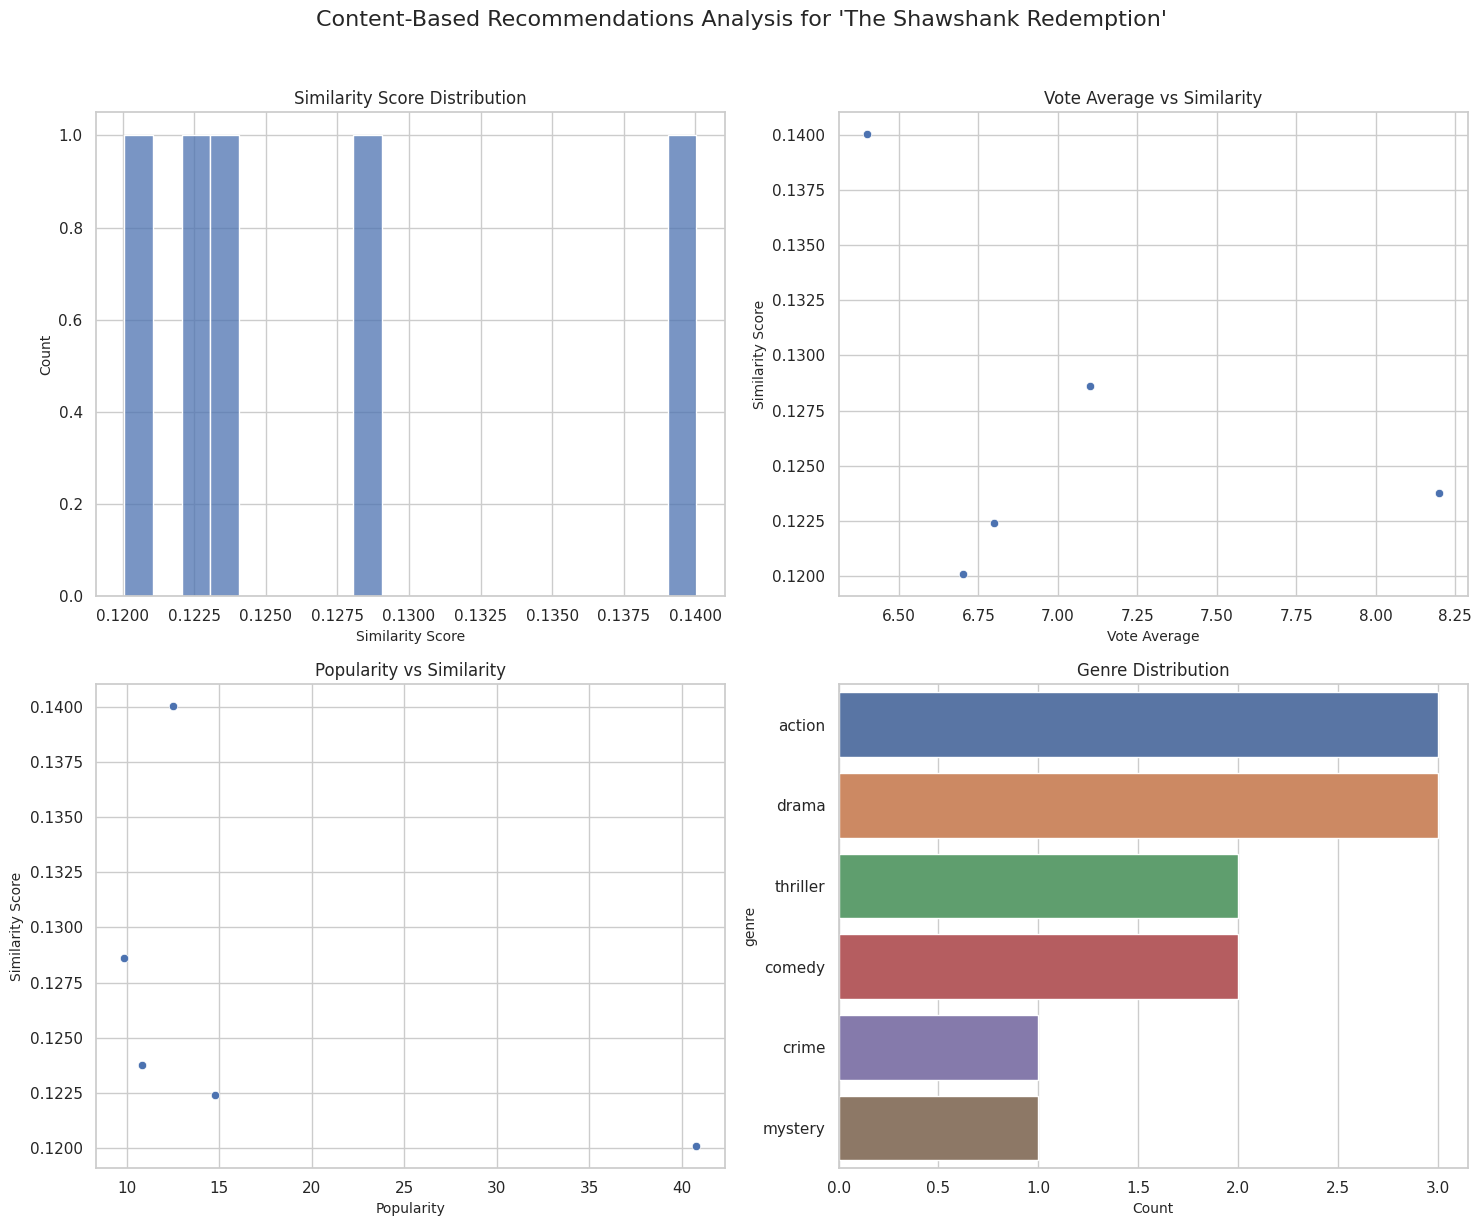


Content-Based Recommendation Metrics:
mean_similarity: 0.127
mean_vote_average: 7.040
mean_popularity: 17.754
unique_genres: 5.000
similarity_std: 0.008
vote_average_range: 1.800

Content-based recommendations:
       title                 genre  similarity_score  vote_average
     In Hell action,drama,thriller          0.140036           6.4
    Brubaker           crime,drama          0.128605           7.1
Sherlock Jr. action,comedy,mystery          0.123766           8.2
  Demolition          comedy,drama          0.122385           6.8
 Escape Plan       action,thriller          0.120067           6.7


In [4]:
# Initialize and train content-based system
content_based_system = ContentBasedRecommender()
print("Training Content-Based Recommender...")
content_based_system.fit(movies_df)

# Get content-based recommendations
movie_title = 'The Shawshank Redemption'
n_recommendations = 5
print(f"\nGenerating content-based recommendations for '{movie_title}'...")
content_recommendations = content_based_system.recommend(movie_title, n_recommendations)

# Plot content-based metrics
plot_recommendation_metrics(content_recommendations, f"Content-Based Recommendations Analysis for '{movie_title}'")
plt.show()

# Print content-based metrics and recommendations
print("\nContent-Based Recommendation Metrics:")
cb_metrics = calculate_recommendation_metrics(content_recommendations)
for metric, value in cb_metrics.items():
    print(f"{metric}: {value:.3f}")

print("\nContent-based recommendations:")
print(content_recommendations[['title', 'genre', 'similarity_score', 'vote_average']].to_string(index=False))

## Collaborative Filtering Recommender

This cell focuses on the collaborative filtering approach. We initialize, train, and generate recommendations based on user interaction data.

**Description:**
- **Initialization and Training**: Creates an instance of `CollaborativeFilteringRecommender` and trains it using the `movies_df` dataset.
- **Generating Recommendations**: Retrieves the top 5 collaborative filtering-based recommendations for *'The Shawshank Redemption'*.
- **Visualization**: Similar to the content-based system, it visualizes various metrics related to the recommendations.
- **Metrics and Output**: Computes and displays evaluation metrics, and lists the recommended movies along with their genres, similarity scores, and weighted ratings.


Training Collaborative Filtering Recommender...
Creating user-movie matrix...
Calculating collaborative filtering similarity matrix...
Collaborative filtering similarity matrix calculated!

Generating collaborative filtering recommendations for 'The Shawshank Redemption'...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


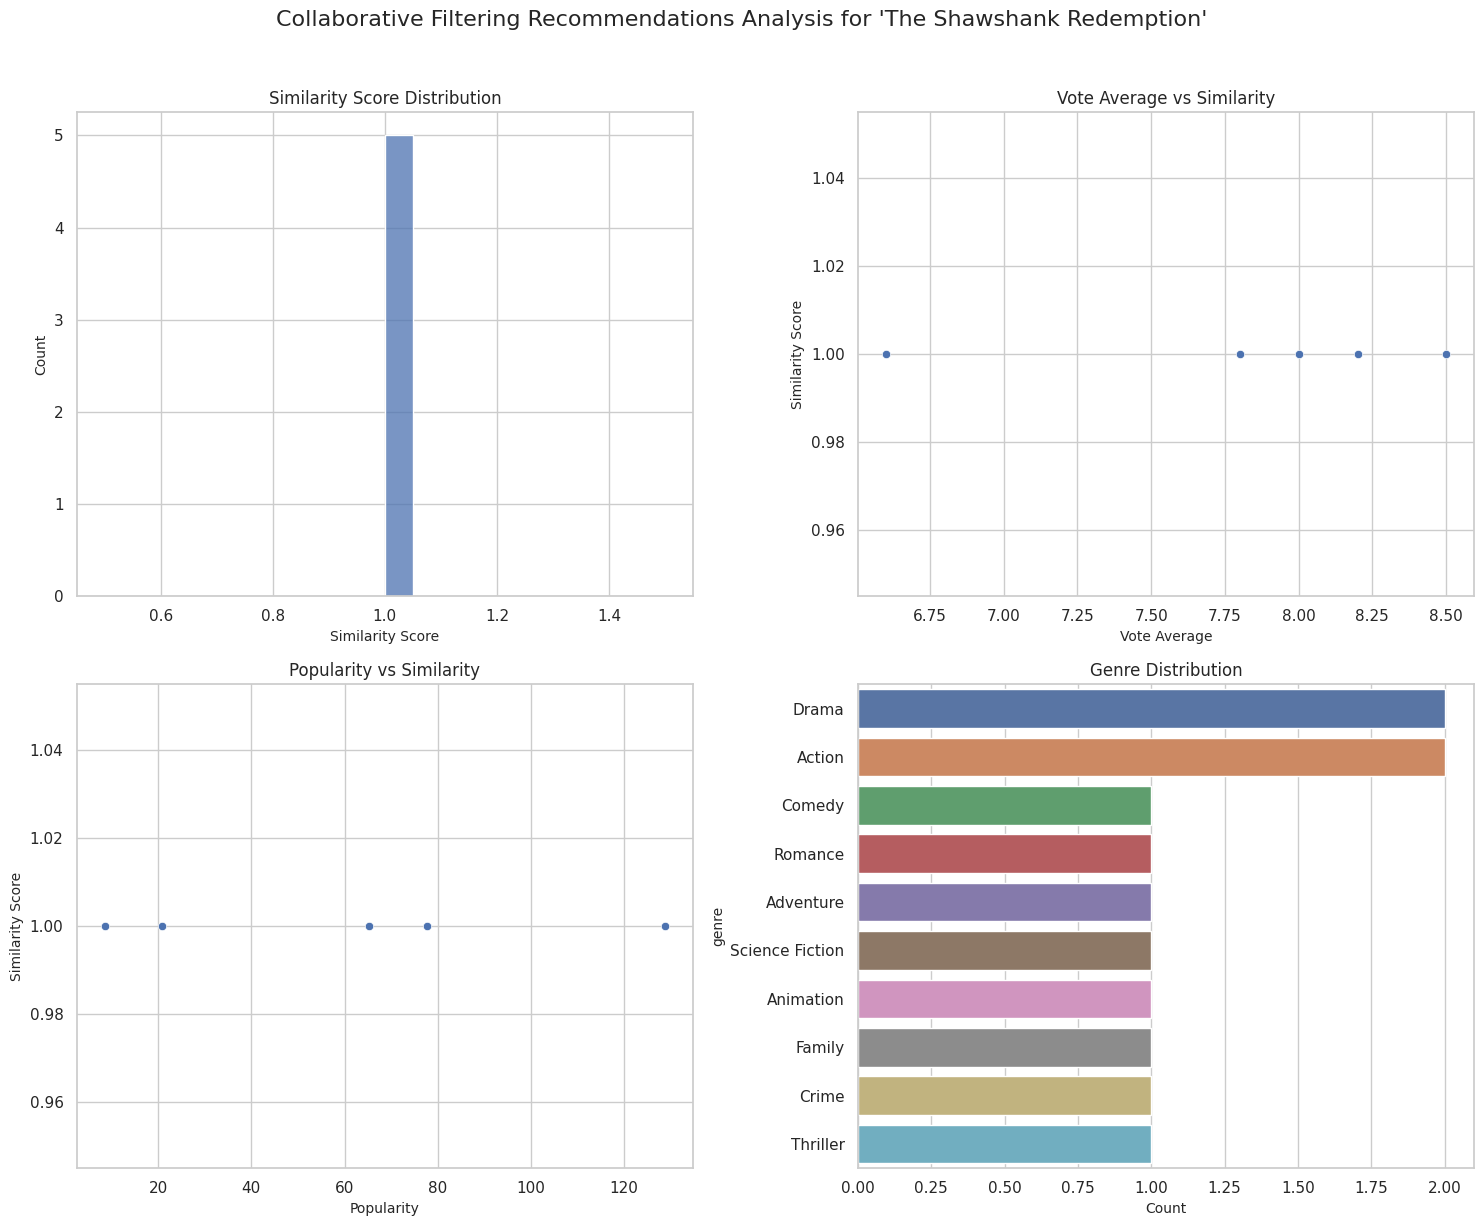


Collaborative Filtering Recommendation Metrics:
mean_similarity: 1.000
mean_vote_average: 7.820
mean_popularity: 60.213
unique_genres: 5.000
similarity_std: 0.000
vote_average_range: 1.900

Collaborative filtering recommendations:
          title                            genre  similarity_score  weighted_rating
   Forrest Gump             Comedy,Drama,Romance               1.0         8.234624
      Star Wars Adventure,Action,Science Fiction               1.0         7.919014
American Beauty                            Drama               1.0         7.631004
   Finding Nemo                 Animation,Family               1.0         7.581187
 Judgment Night            Action,Crime,Thriller               1.0         6.619854


In [5]:
# Initialize and train collaborative system
collaborative_system = CollaborativeFilteringRecommender()
print("Training Collaborative Filtering Recommender...")
collaborative_system.fit(movies_df)

# Get collaborative recommendations
print(f"\nGenerating collaborative filtering recommendations for '{movie_title}'...")
collab_recommendations = collaborative_system.recommend(movie_title, n_recommendations)

# Plot collaborative metrics
plot_recommendation_metrics(collab_recommendations, f"Collaborative Filtering Recommendations Analysis for '{movie_title}'")
plt.show()

# Print collaborative metrics and recommendations
print("\nCollaborative Filtering Recommendation Metrics:")
cf_metrics = calculate_recommendation_metrics(collab_recommendations)
for metric, value in cf_metrics.items():
    print(f"{metric}: {value:.3f}")

print("\nCollaborative filtering recommendations:")
print(collab_recommendations[['title', 'genre', 'similarity_score', 'weighted_rating']].to_string(index=False))

## Comparison Analysis

The final cell compares the performance and outputs of both recommendation systems, providing a comprehensive overview of their similarities and differences.

**Description:**
- **Visualization**: Generates side-by-side bar charts comparing vote averages and similarity scores between the content-based and collaborative filtering recommendations.
- **Comparison DataFrame**: Constructs a DataFrame that juxtaposes the recommended movie titles and their respective similarity scores from both systems.
- **Output**: Displays the comparison DataFrame, allowing for an easy side-by-side evaluation of the recommendations provided by each system.


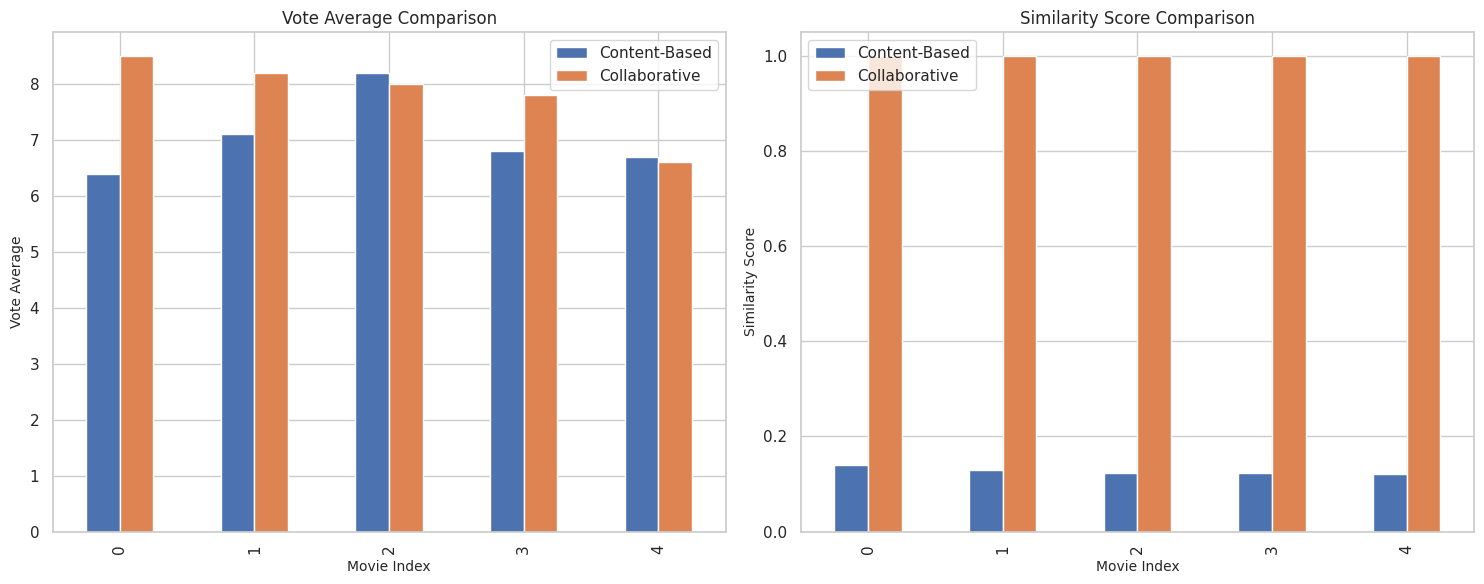


Recommendation Systems Comparison:
Content-Based  CB Similarity   Collaborative  CF Similarity
      In Hell       0.140036    Forrest Gump            1.0
     Brubaker       0.128605       Star Wars            1.0
 Sherlock Jr.       0.123766 American Beauty            1.0
   Demolition       0.122385    Finding Nemo            1.0
  Escape Plan       0.120067  Judgment Night            1.0


In [6]:
# Compare both recommendation systems
pd.set_option('display.max_columns', None)

# Plot comparison visualizations
compare_recommendations(content_recommendations, collab_recommendations)
plt.show()

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Content-Based': content_recommendations['title'].values,
    'CB Similarity': content_recommendations['similarity_score'].values,
    'Collaborative': collab_recommendations['title'].values,
    'CF Similarity': collab_recommendations['similarity_score'].values
})

print("\nRecommendation Systems Comparison:")
print(comparison_df.to_string(index=False))

### Comparison Results

Let's comparison results between Content-Based and Collaborative Filtering recommendations:

1. **Content-Based Recommendations**:
- These recommendations are based on similar movie features (plot, genre, themes)
- The similarity scores are relatively low (0.12-0.14) because they're based on text similarity
- The recommended movies like "In Hell", "Brubaker", and "Escape Plan" share themes with Shawshank Redemption:
  - Prison/incarceration settings
  - Themes of justice and survival
  - Drama elements

2. **Collaborative Filtering Recommendations**:
- These recommendations are based on user voting patterns
- The similarity scores are all 1.0, indicating these movies have very similar user rating patterns
- The recommended movies ("Forrest Gump", "Star Wars", "American Beauty") are:
  - Highly-rated classics
  - Popular films with strong audience reception
  - Movies that people who like Shawshank Redemption typically also enjoy

3. **Key Differences**:
- Content-based focuses on thematic similarity (prison dramas, similar narratives)
- Collaborative filtering focuses on viewer behavior (what movies are liked by the same audience)
- The collaborative approach recommends more mainstream classics, while content-based finds more niche movies with similar themes

4. **Interpretation**:
- Content-based is better at finding movies with similar themes/content
- Collaborative filtering is better at finding movies with similar audience appeal
- The high similarity scores (1.0) in collaborative filtering suggest these movies have very strong overlap in their viewer base with Shawshank Redemption

## Summary

In this notebook, we successfully built and analyzed two distinct movie recommendation systems using the Top 10k TMDB Movies Dataset:

1. **Content-Based Recommender**: Leveraged textual data (overviews and genres) to find similar movies based on content similarity.
2. **Collaborative Filtering Recommender**: Utilized user interaction metrics (vote averages and counts) to identify and recommend movies based on collective user preferences.

Through visualizations and metric calculations, we compared the effectiveness of both systems, providing insights into their respective strengths. The content-based approach excels in understanding the intrinsic features of movies, while the collaborative filtering method shines in capturing collective user preferences and ratings.

This comprehensive analysis lays the groundwork for further enhancements, such as hybrid recommendation systems that combine both approaches to deliver more personalized and accurate movie suggestions.
